# 1 - Getting Started

The main application for `scikit-gstat` is variogram analysis and [Kriging](https://en.wikipedia.org/wiki/Kriging). This Tutorial will guide you through the most basic functionality of `scikit-gstat`. There are other tutorials that will explain specific methods or attributes in `scikit-gstat` in more detail.

#### What you will learn in this tutorial

* How to instantiate `Variogram` and `OrdinaryKriging`
* How to read a variogram
* Perform an interpolation
* Most basic plotting


In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
plt.style.use('ggplot')

The `Variogram` and `OrdinaryKriging` classes can be loaded directly from `skgstat`. This is the name of the Python module.

In [2]:
from skgstat import Variogram, OrdinaryKriging

At the current version, there are some deprecated attributes and method in the `Variogram` class. They do not raise `DeprecationWarning`s, but rather print a warning message to the screen. You can suppress this warning by adding an `SKG_SUPPRESS` environment variable

In [3]:
%set_env SKG_SUPPRESS=true

env: SKG_SUPPRESS=true


## 1.1 Load data

You can find a prepared example data set in the `./data` subdirectory. This example is extracted from a generated Gaussian random field. We can expect the field to be stationary and show a nice spatial dependence, because it was created that way.
We can load one of the examples and have a look at the data:

In [4]:
data = pd.read_csv('./data/sample_sr.csv')
print("Loaded %d rows and %d columns" % data.shape)
data.head()

Loaded 200 rows and 3 columns


,x,y,z
0,94,20,-0.394444
1,82,37,-2.283663
2,43,13,-0.546213
3,78,42,-3.681384
4,50,28,0.504538


Get a first overview of your data by plotting the `x` and `y` coordinates and visually inspect how the `z` spread out.

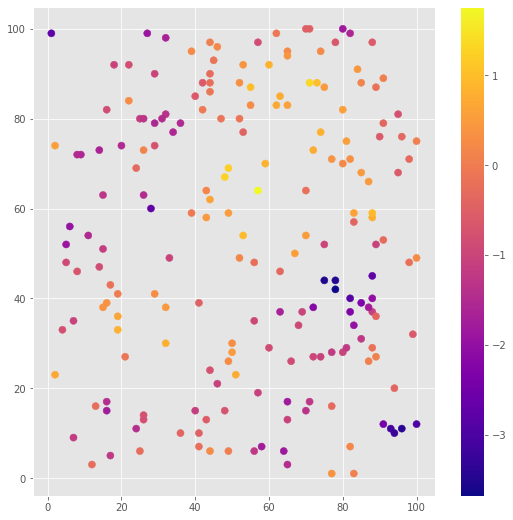

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(9, 9))
art = ax.scatter(data.x,data.y, s=50, c=data.z, cmap='plasma')
plt.colorbar(art);

We can already see a lot from here: 

* The small values seem to concentrate on the upper left and lower right corner
* Larger values are arranged like a band from lower left to upper right corner
* To me, each of these blobs seem to have a diameter of something like 30 or 40 units.
* The distance between the minimum and maximum seems to be not more than 60 or 70 units.

These are already very important insights.

## 1.2 Build a Variogram

As a quick reminder, the variogram relates pair-wise separating distances of `coordinates` and relates them to the *semi-variance* of the corresponding `values` pairs. The default estimator used is the Matheron estimator:

$$ \gamma (h) = \frac{1}{2N(h)} * \sum_{i=1}^{N(h)}(Z(x_i) - Z(x_{i + h}))^2 $$

For more details, please refer to the [User Guide](https://mmaelicke.github.io/scikit-gstat/userguide/variogram.html#experimental-variograms)

The `Variogram` class takes at least two arguments. The `coordinates` and the `values` observed at these locations. 
You should also at least set the `normalize` parameter to explicitly, as it changes it's default value in version `0.2.8` to `False`. This attribute affects only the plotting, not the variogram values.
Additionally, the number of bins is set to 15, because we have fairly many observations and the default value of 10 is unnecessarily small. The `maxlag` set the maximum distance for the last bin. We know from the plot above, that more than 60 units is not really meaningful

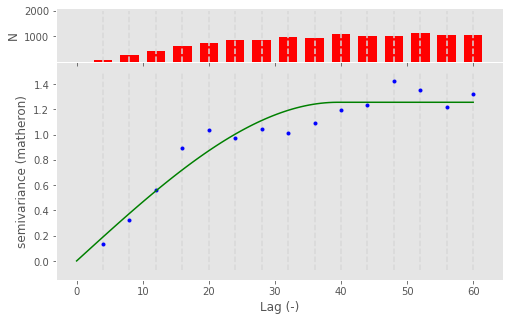

In [6]:
V = Variogram(data[['x', 'y']].values, data.z.values, normalize=False, maxlag=60, n_lags=15)
fig = V.plot(show=False)

The upper subplot show the histogram for the count of point-pairs in each lag class. You can see various things here:

* As expected, there is a clear spatial dependency, because semi-variance increases with distance (blue dots)
* The default `spherical` variogram model is well fitted to the experimental data
* The shape of the dependency is **not** captured quite well, but fair enough for this example

The sill of the variogram should correspond with the field variance. The field is unknown, but we can compare the sill to the *sample* variance:

In [7]:
print('Sample variance: %.2f   Variogram sill: %.2f' % (data.z.var(), V.describe()['sill']))

Sample variance: 1.10   Variogram sill: 1.26


The `describe` method will return the most important parameters as a dictionary. And we can simply print the variogram ob,ect to the screen, to see all parameters.

In [8]:
pprint(V.describe())

{'effective_range': 39.50027313170537,
 'estimator': 'matheron',
 'name': 'spherical',
 'nugget': 0,
 'sill': 1.2553698556802062}


In [9]:
print(V)

spherical Variogram
-------------------
Estimator:         matheron
Effective Range:   39.50
Sill:              1.26
Nugget:            0.00
        


## 1.3 Kriging

The Kriging class will now use the Variogram from above to estimate the Kriging weights for each grid cell. This is done by solving a linear equation system. For an unobserved location $s_0$, we can use the distances to 5 observation points and build the system like:

$$
\begin{pmatrix}
\gamma(s_1, s_1) & \gamma(s_1, s_2) & \gamma(s_1, s_3) & \gamma(s_1, s_4) & \gamma(s_1, s_5) & 1\\
\gamma(s_2, s_1) & \gamma(s_2, s_2) & \gamma(s_2, s_3) & \gamma(s_2, s_4) & \gamma(s_2, s_5) & 1\\
\gamma(s_3, s_1) & \gamma(s_3, s_2) & \gamma(s_3, s_3) & \gamma(s_3, s_4) & \gamma(s_3, s_5) & 1\\
\gamma(s_4, s_1) & \gamma(s_4, s_2) & \gamma(s_4, s_3) & \gamma(s_4, s_4) & \gamma(s_4, s_5) & 1\\
\gamma(s_5, s_1) & \gamma(s_5, s_2) & \gamma(s_5, s_3) & \gamma(s_5, s_4) & \gamma(s_5, s_5) & 1\\
1 & 1 & 1 & 1 & 1 & 0 \\
\end{pmatrix} *
\begin{bmatrix}
\lambda_1 \\
\lambda_2 \\
\lambda_3 \\
\lambda_4 \\
\lambda_5 \\
\mu \\
\end{bmatrix} =
\begin{pmatrix}
\gamma(s_0, s_1) \\
\gamma(s_0, s_2) \\
\gamma(s_0, s_3) \\
\gamma(s_0, s_4) \\
\gamma(s_0, s_5) \\
1 \\
\end{pmatrix}
$$

For more information, please refer to the [User Guide](https://mmaelicke.github.io/scikit-gstat/userguide/kriging.html#kriging-equation-system)

Consequently, the `OrdinaryKriging` class needs a `Variogram` object as a mandatory attribute. Two very important optional attributes are `min_points` and `max_points`. They will limit the size of the Kriging equation system. As we have 200 observations, we can require at least 5 neighbors within the range. More than 15 will only unnecessarily slow down the computation. The `mode='exact'` attribute will advise the class to build and solve the system above for each location.

In [10]:
ok = OrdinaryKriging(V, min_points=5, max_points=15, mode='exact')

The `transform` method will apply the interpolation for passed arrays of coordinates. It requires each dimension as a single 1D array. We can easily build a meshgrid of 100x100 coordinates and pass them to the interpolator. To recieve a 2D result, we can simply reshape the result. The Kriging error will be available as the `sigma` attribute of the interpolator.

In [11]:
# build the target grid
xx, yy = np.mgrid[0:99:100j, 0:99:100j]
field = ok.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)
s2 = ok.sigma.reshape(xx.shape)

And finally, we can plot the result.

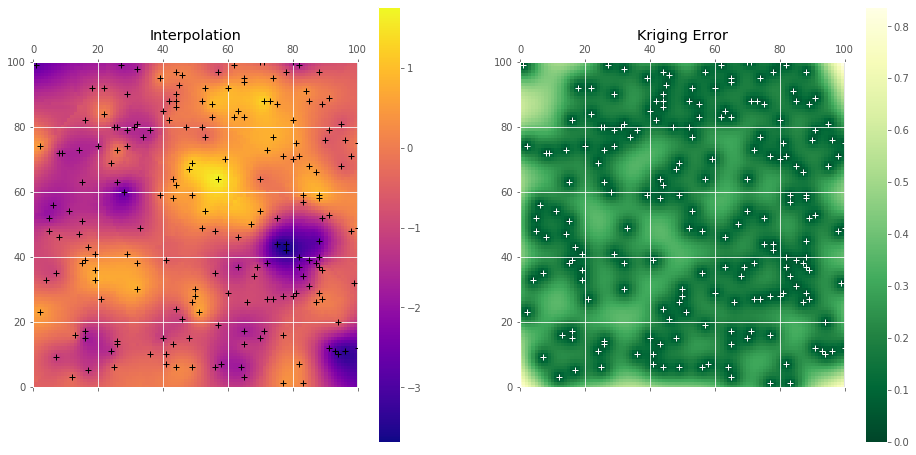

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

art = axes[0].matshow(field.T, origin='lower', cmap='plasma')
axes[0].set_title('Interpolation')
axes[0].plot(data.x, data.y, '+k')
axes[0].set_xlim((0,100))
axes[0].set_ylim((0,100))
plt.colorbar(art, ax=axes[0])
art = axes[1].matshow(s2.T, origin='lower', cmap='YlGn_r')
axes[1].set_title('Kriging Error')
plt.colorbar(art, ax=axes[1])
axes[1].plot(data.x, data.y, '+w')
axes[1].set_xlim((0,100))
axes[1].set_ylim((0,100));

From the Kriging error map, you can see how the interpolation is very certain close to the observation points, but rather high in areas with only little coverage (like the upper left corner).